# Regresión Logística en Python — Supervivencia del Titanic
**Duración:** ~30 minutos  
**Objetivo:** Ajustar e interpretar una regresión logística para predecir la supervivencia en el Titanic usando características simples.

### Objetivos de Aprendizaje
- Entender la regresión logística como un GLM con el enlace **logit**.
- Ajustar regresión logística con **statsmodels** y **scikit-learn**.
- Interpretar coeficientes (razones de momios) y evaluar con precisión, ROC AUC, y matriz de confusión.


In [1]:
# Configuración
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt

# Opciones de visualización
pd.set_option('display.max_columns', 100)

## ¿Qué es la Regresión Logística?

La **regresión logística** es un modelo lineal generalizado (GLM) que se utiliza para predecir **variables binarias** (0/1, No/Sí, Fracaso/Éxito). A diferencia de la regresión lineal que predice valores continuos, la regresión logística predice **probabilidades** que están restringidas al intervalo [0, 1].

**Función logística (sigmoide):**
$$
p(x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_k x_k)}}
$$

**Función de enlace logit:**
$$
\text{logit}(p) = \ln\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_k x_k
$$

**Propiedades clave:**
- **Rango:** Las probabilidades predichas están siempre entre 0 y 1.
- **Forma S:** La función logística tiene forma de "S" (sigmoide).
- **Interpretación:** Los coeficientes representan el cambio en **log-odds** por unidad de cambio en la variable predictora.

**Casos de uso:**
- Predicción de supervivencia (vivo/muerto).
- Clasificación de correos (spam/no spam).
- Diagnóstico médico (enfermo/sano).
- Aprobación de créditos (aprobado/rechazado).
- Marketing (compra/no compra).

**Razón de posibilidades (Odds Ratios):**
Los **odds** son la razón entre la probabilidad de éxito y la probabilidad de fracaso:
$$
\text{Odds} = \frac{p}{1-p}
$$

La **razón de posibilidades** para una variable $x_i$ es:
$$
\text{OR}_i = e^{\beta_i}
$$

- Si $\text{OR} > 1$: La variable aumenta la probabilidad del evento.
- Si $\text{OR} < 1$: La variable disminuye la probabilidad del evento.
- Si $\text{OR} = 1$: La variable no tiene efecto en la probabilidad.

> La regresión logística es especialmente útil cuando necesitamos no solo clasificar, sino también obtener **probabilidades calibradas** y entender la **importancia relativa** de cada predictor.

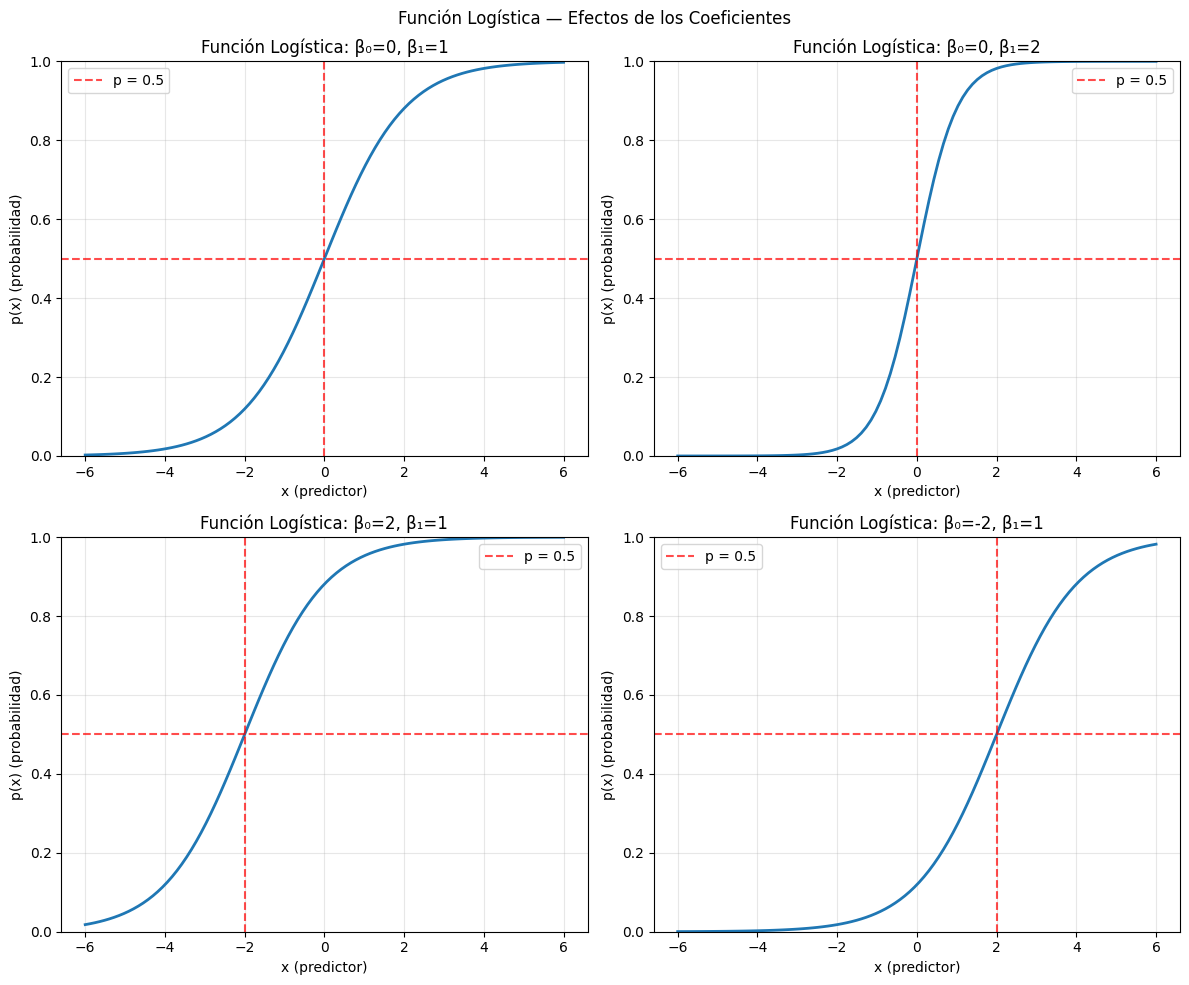

In [ ]:
# Visualización de la función logística (sigmoide) para diferentes coeficientes
import numpy as np
import matplotlib.pyplot as plt

# Rango de valores para x
x = np.linspace(-6, 6, 100)

# Diferentes combinaciones de intercepto (β₀) y pendiente (β₁)
params = [
    (0, 1),    # β₀=0, β₁=1 (función logística estándar)
    (0, 2),    # β₀=0, β₁=2 (más pendiente)
    (2, 1),    # β₀=2, β₁=1 (desplazada hacia la izquierda)
    (-2, 1)    # β₀=-2, β₁=1 (desplazada hacia la derecha)
]

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, (beta0, beta1) in enumerate(params):
    # Función logística: p = 1 / (1 + exp(-(β₀ + β₁*x)))
    logit = beta0 + beta1 * x
    p = 1 / (1 + np.exp(-logit))
    
    axes[i].plot(x, p, linewidth=2)
    axes[i].axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='p = 0.5')
    axes[i].axvline(x=-beta0/beta1, color='red', linestyle='--', alpha=0.7)
    axes[i].set_xlabel('x (predictor)')
    axes[i].set_ylabel('p(x) (probabilidad)')
    axes[i].set_title(f'Función Logística: β₀={beta0}, β₁={beta1}')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 1)
    axes[i].legend()

plt.suptitle('Función Logística — Efectos de los Coeficientes')
plt.tight_layout()
plt.show()

## 1) Cargar e Inspeccionar los Datos
Usaremos el conjunto de datos `titanic` incorporado en **Seaborn**.

In [3]:

titanic = sns.load_dataset("titanic")
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [4]:
# Información básica y verificaciones rápidas
print(titanic.shape)
print(titanic.isna().mean().round(3))
titanic['survived'].value_counts(normalize=True).rename('tasa_supervivencia')

(891, 15)
survived       0.000
pclass         0.000
sex            0.000
age            0.199
sibsp          0.000
parch          0.000
fare           0.000
embarked       0.002
class          0.000
who            0.000
adult_male     0.000
deck           0.772
embark_town    0.002
alive          0.000
alone          0.000
dtype: float64


survived
0    0.616162
1    0.383838
Name: tasa_supervivencia, dtype: float64

## 2) Preprocesamiento Mínimo
Mantendremos las cosas simples:
- Seleccionar algunos predictores: `age`, `fare`, `sex`, `class`
- Eliminar filas con valores faltantes en estas columnas
- Codificar variables categóricas con one-hot encoding

In [5]:
cols = ["age", "fare", "sex", "class", "survived"]
df = titanic[cols].dropna().copy()

# Codificar
df["sex"] = df["sex"].map({"male": 0, "female": 1})
X = pd.get_dummies(df[["age", "fare", "sex", "class"]], drop_first=True)
y = df["survived"].astype(int)

X.head()

,age,fare,sex,class_Second,class_Third
0,22.0,7.2500,0,False,True
1,38.0,71.2833,1,False,False
2,26.0,7.9250,1,False,True
3,35.0,53.1000,1,False,False
4,35.0,8.0500,0,False,True


## 3) Ajustar con **statsmodels** (Logit) para Interpretabilidad
Incluiremos una intersección y veremos las estimaciones de los coeficientes. También calcularemos las **razones de momios**.

In [6]:
# Convertir columnas booleanas a enteros para compatibilidad con statsmodels
X_sm = sm.add_constant(X.astype(int))
logit_model = sm.Logit(y, X_sm).fit(disp=False)
logit_summary = logit_model.summary()
logit_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      708
Method:                           MLE   Df Model:                            5
Date:                Thu, 06 Nov 2025   Pseudo R-squ.:                  0.3290
Time:                        13:44:50   Log-Likelihood:                -323.59
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 1.867e-66
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.2045      0.419      2.875      0.004       0.383       2.026
age             -0.0367      0.008     -4.756      0.000      -0.052      -0.022
fare             0.0005      0.002      0.227      0.821      -0.004       0.005
sex              2.5191      0.208     12.099      0.000       2.111       2.927
class_Second    -1.2781      0.312     -4.090      0.000      -1.890      -0.666
class_Third     -2.5428      0.328     -7.756      0.000      -3.185      -1.900
================================================================================
"""

In [7]:
# Razones de momios (exponencial de los coeficientes)
odds_ratios = np.exp(logit_model.params).rename("razon_momios")
odds_ratios.to_frame()

,razon_momios
const,3.335025
age,0.963938
fare,1.000512
sex,12.416961
class_Second,0.278576
class_Third,0.078649


## 4) Entrenar/Probar con **scikit-learn** para Predicción
Evaluaremos con precisión, matriz de confusión, curva ROC, y AUC.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

print("Precisión:", round(accuracy_score(y_test, y_pred), 3))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

Precisión: 0.804

Matriz de confusión:
 [[89 17]
 [18 55]]

ROC AUC: 0.852

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.83      0.84      0.84       106
           1       0.76      0.75      0.76        73

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179



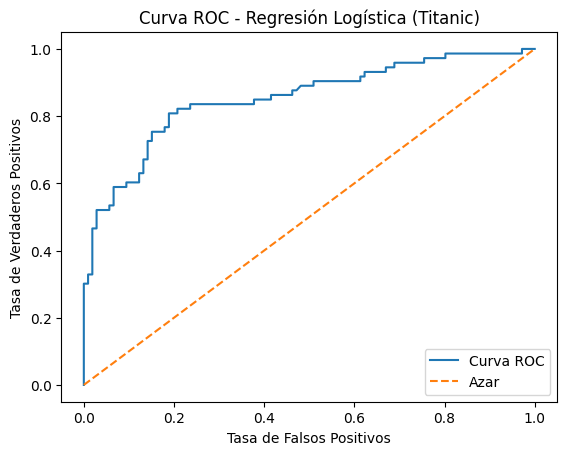

In [9]:
# Curva ROC (solo matplotlib; un gráfico; sin colores explícitos)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr, label="Curva ROC")
plt.plot([0,1], [0,1], linestyle="--", label="Azar")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - Regresión Logística (Titanic)")
plt.legend(loc="lower right")
plt.show()

## 5) Conclusiones
- Los coeficientes en regresión logística son **log-odds**; exponenciarlos da las **razones de momios**.
- Las características continuas (ej., `age`, `fare`) cambian los log-odds por cambio unitario.
- Las variables dummy categóricas (ej., `class_Second`, `class_Third`) son relativas a la línea base (`First`).

---

## 🧪 Ejercicios
1. **Simplificar el modelo:** Ajusta un modelo con solo `age` y `sex`. Compara el AUC con el modelo completo.  
2. **Agregar características:** Intenta agregar `sibsp` y `parch` (hermanos/padres a bordo). ¿Cambia el rendimiento?  
3. **Calibrar umbrales:** En lugar de 0.5, elige un umbral que equilibre precisión y recall para la clase positiva.  
4. **Interpretación:** Usando el logit de statsmodels, calcula e interpreta la razón de momios para `sex` y `class_Third`.